In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl; import matplotlib.pyplot as plt; from matplotlib import cm
import seaborn as sns
import datetime; from datetime import datetime
import mpld3; from mpld3 import plugins

mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 

# Add this to python2 code to make life easier
from __future__ import absolute_import, division, print_function

## Read datasets

In [2]:
df_geography = pd.read_csv('delivery_geography.csv') #Read it as a pandas dataframe
print('The geography table contains', len(df_geography), 'rows')
df_geography.head()

The geography table contains 3780 rows


,orderid,latitude,longitude,estimateddeliverytime
0,1552679,37.697073,-122.485903,259.0
1,1552697,37.782185,-122.454544,54.0
2,1552675,37.780840,-122.395820,228.0
3,1552934,37.783131,-122.388962,209.0
4,1552983,37.323786,-121.878904,345.0


In [3]:
df_prices = pd.read_csv('delivery_prices.csv')
print('The prices table contains', len(df_prices), 'rows')
df_prices.head()

The prices table contains 3352 rows


,orderid,deliveredat,totalprice
0,1552553,2017-08-08T00:02:29.980+00:00,176.11
1,1552559,2017-08-08T00:09:06.077+00:00,71.03
2,1552499,2017-08-08T00:15:03.847+00:00,61.95
3,1552617,2017-08-08T00:16:40.820+00:00,62.40
4,1552632,2017-08-08T00:31:27.957+00:00,64.16


In [4]:
## Change deliveredat date str to date format
import datetime

df_prices['date'] = df_prices['deliveredat'].apply(lambda x: datetime.date(int(x[0:4]), int(x[5:7]), int(x[8:10])))
df_prices['time'] = df_prices['deliveredat'].apply(lambda x: int(x[11:13]) + int(x[14:16])*60 + float(x[17:23])*3600)

In [5]:
print('There are', len(df_prices['date'].unique()), 'unique dates, corresponding to:', df_prices['date'][0])
df_prices.head(3)

There are 1 unique dates, corresponding to: 2017-08-08


,orderid,deliveredat,totalprice,date,time
0,1552553,2017-08-08T00:02:29.980+00:00,176.11,2017-08-08,108048.0
1,1552559,2017-08-08T00:09:06.077+00:00,71.03,2017-08-08,22417.2
2,1552499,2017-08-08T00:15:03.847+00:00,61.95,2017-08-08,14749.2


## Q1: Join these two tables in a meaningful way.
Both tables contain the "orderid" column, which appears in common in most of the entries of both "price" and "geography" tables. I will merge the tables based on this.

In [6]:
df = pd.merge(df_geography, df_prices, on='orderid')
df.drop('date', axis=1, inplace=True)
df.drop('deliveredat', axis=1, inplace=True)
print('The merged table contains', len(df), 'rows including the information of prices whenever it is available') #3283
print('We keep',len(df)/len(df_geography)*100, 'rows')
df.head()

The merged table contains 3283 rows including the information of prices whenever it is available
We keep 86.85185185185185 rows


,orderid,latitude,longitude,estimateddeliverytime,totalprice,time
0,1552679,37.697073,-122.485903,259.0,48.36,126469.2
1,1552697,37.782185,-122.454544,54.0,46.86,3540.0
2,1552675,37.780840,-122.395820,228.0,64.39,205930.8
3,1552934,37.783131,-122.388962,209.0,81.51,70523.8
4,1552983,37.323786,-121.878904,345.0,74.80,75505.0


I decided to use an inner join in the merge and discard the information which does not appears in both tables, because most of the rows have common information and only 13% of the rows do not appear in either one of the individual tables.

## Q2: Find at least one source of external information that you think would augment this table well and add it into the joined table.

It would be interesting to link the (lat, lon) location to the zip code, so we can get more information about different areas. <br>
The geopy and pygeocoder (this one has an "OVER_QUERY_LIMIT") packages allows us to do that. 

In [7]:
from pygeocoder import Geocoder

def get_city(latd,long):
    location = Geocoder.reverse_geocode(latd,long)
    city = location.city
    return city

In [9]:
results = Geocoder.reverse_geocode(df['latitude'][11], df['longitude'][11])

results.coordinates
results.country
results.administrative_area_level_1
results.city
#results.street_address
#results.postal

'San Francisco'

The function Geocoder from the package pygeocoder has an "OVER_QUERY_LIMIT", when using the API. <br>
Let's try geopy.geocoders from Nominatim

In [10]:
lat = df.latitude.astype(str)
lon = df.longitude.astype(str)
lat_lon = [lat,lon]
#geolocator.reverse([lat[0], lon[0]])

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

def get_zip_code(latd,long):
    location = geolocator.reverse([latd,long])
    data = location.raw
    
    data = data['address']
    if 'postcode' in data.keys():
        address = str(data)
        postalCode = str(data['postcode'])
    else:
        postalCode = float('nan')
    return postalCode

def get_city_name(latd,long):
    location = geolocator.reverse([latd,long])
    data = location.raw
    
    data = data['address']
    if 'city' in data.keys():
        address = str(data)
        city = str(data['city'])
    else:
        city = float('nan')
    return city

#i=7
#print(get_zip_code(lat[i],lon[i]))
#print(get_city_name(lat[i],lon[i]))

In [12]:
postcode = []
city = []
#for i in range(len(lat)):
for i in range(5):
    postcode.append(get_zip_code(lat[i],lon[i]))
    city.append(get_city_name(lat[i],lon[i]))
    
#city

In [13]:
df['zip'] = np.full(len(df), np.nan); df['city'] = np.full(len(df), np.nan)
df['zip'][0:len(postcode)] = postcode; df['city'][0:len(postcode)] = city
df.head()

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,orderid,latitude,longitude,estimateddeliverytime,totalprice,time,zip,city
0,1552679,37.697073,-122.485903,259.0,48.36,126469.2,94132,Daly City
1,1552697,37.782185,-122.454544,54.0,46.86,3540.0,94118,SF
2,1552675,37.780840,-122.395820,228.0,64.39,205930.8,94107,SF
3,1552934,37.783131,-122.388962,209.0,81.51,70523.8,94107,SF
4,1552983,37.323786,-121.878904,345.0,74.80,75505.0,95113,San José


In [15]:
for i in range(490,495):
    df['zip'].loc[(df.latitude == np.float(lat[i])) & (df.longitude == np.float(lon[i]))] = get_zip_code(lat[i],lon[i])
    df['city'].loc[(df.latitude == np.float(lat[i])) & (df.longitude == np.float(lon[i]))] = get_city_name(lat[i],lon[i])

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
df[490:493]

,orderid,latitude,longitude,estimateddeliverytime,totalprice,time,zip,city
490,1553755,37.375516,-122.036446,94.0,50.45,7909.8,94086,Sunnyvale
491,1553735,37.819650,-122.257170,21.0,174.81,71187.0,94611,Oakland
492,1553867,37.392287,-122.063588,273.0,86.74,199033.8,94043,Mountain View


Querying the information from the google API can be tedious and very slow... to rerun this part of the code and obtain the zip and city associated to the [latitude, longitude] coordinates, mark the cell as code. <br>
To save time, I saved the resulting dataframe (with all the three components (location, price, zip+city) in a csv file) that is going to be loaded below:

In [17]:
df_all = pd.read_csv('extended_datafile.csv', sep='\t')
df_all.drop('Unnamed: 0', axis=1, inplace=True)
df_all.tail()

,orderid,latitude,longitude,estimateddeliverytime,totalprice,zip,city,time
3278,1556097,37.728544,-122.449036,60.0,57.34,94132,San Francisco,22.508825
3279,1556008,34.005590,-118.487067,121.0,108.79,NaN,Santa Monica,23.300415
3280,1556044,37.736616,-122.470187,199.0,40.56,94127,San Francisco,23.628380
3281,1556137,37.374769,-122.056407,216.0,55.24,94086,Sunnyvale,23.981333
3282,1556269,37.771681,-122.507414,30.0,137.11,94122,San Francisco,23.922099


## Q3: Explain (at a high level) how you would perform this join on a live data pipeline in a performant way.

Check if the address associated to the location is a real one:

In [24]:
i=11
city = get_city_name(df.latitude[i],df.longitude[i])
result = Geocoder.reverse_geocode(df['latitude'][i], df['longitude'][i])

None


In [27]:
#if Geocoder.geocode(address).valid_address == True:
if Geocoder.geocode("4207 N Washington Ave, Douglas, AZ 85607").valid_address == True:
    print('Valid address')
    result = Geocoder.geocode("7250 South Tucson Boulevard, Tucson, AZ 85756")
    print('Street name:', result.route)
    print('House #:', result.street_number)
    #result.postal

Valid address
Street name: South Tucson Boulevard
House #: 7250


If the table already contains a column with the city name and zip code, and we want to include the city name for a new [latitude,longitude] entry, one can search for the [latitude,longitude] entry and update the city and zip code as it comes:

In [28]:
i = 8

df['zip'].loc[(df.latitude == np.float(lat[i])) & (df.longitude == np.float(lon[i]))] = get_zip_code(lat[i],lon[i])
df['city'].loc[(df.latitude == np.float(lat[i])) & (df.longitude == np.float(lon[i]))] = get_city_name(lat[i],lon[i])
df[8:9]

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,orderid,latitude,longitude,estimateddeliverytime,totalprice,time,zip,city
8,1553228,37.795776,-122.216076,126.0,42.94,59425.0,94602,Oakland


## Q4: Use any clustering/classification technique to divide the data into at least 3 and at most 20 groups. Annotate your joined table with this classification.

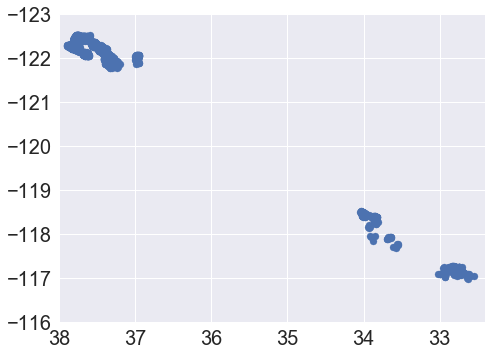

In [29]:
## Let's get some info about the latitude/longitude:
plt.clf()
fig = plt.figure(figsize=(7,5))
plt.scatter(df_all['latitude'],df_all['longitude']); plt.ylim(-116,-123); plt.xlim(38,32.4)
plt.tight_layout()
#plt.savefig('./figs/location_orders.png', bbox_inches='tight')
plt.show()

We can clearly see three different, well defined regions.

In [30]:
from mpl_toolkits.basemap import Basemap
mpld3.enable_notebook()
plt.clf()
fig = plt.figure(figsize=(9,6))

map = Basemap(projection='merc', lat_0=35, lon_0 = -119.5, resolution='h', area_thresh=0.1,
    llcrnrlon=min(df_all.longitude)-0.5, llcrnrlat=min(df_all.latitude)-0.5,
    urcrnrlon=max(df_all.longitude)+0.5, urcrnrlat=max(df_all.latitude)+0.5)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='#cc9955',lake_color='aqua')#cc9955 #coral
map.drawmapboundary()

lon = df_all.longitude; lat = df_all.latitude
x,y = map(np.array(lon), np.array(lat))
map.plot(x, y, 'bo', markersize=4)

plt.tight_layout()
#plt.savefig('./figs/map_location_orders.png', bbox_inches='tight')
mpld3.display()

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Before applying any classification/clustering algorithm, let's rearrange the dataset. The categorical variables will be convered into dummy variables:

In [31]:
mpld3.disable_notebook()

In [32]:
df_city_dummies = pd.get_dummies(df_all['city'])

## Concatenate to the original dataframe:
df_d = pd.concat([df_all, df_city_dummies], axis=1)
df_d.drop('zip', axis=1, inplace=True)
df_d.drop('city', axis=1, inplace=True)
print(df_d.shape)
df_d.head()

(3283, 65)


,orderid,latitude,longitude,estimateddeliverytime,totalprice,time,Alameda,Aptos,Atherton,Belmont,...,Santa Clara,Santa Cruz,Santa Monica,Saratoga,Soquel,South San Francisco,Stanford,Sunnyvale,Torrance,Woodside
0,1552679,37.697073,-122.485903,259.0,48.36,0.041661,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1552697,37.782185,-122.454544,54.0,46.86,0.151688,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1552675,37.780841,-122.395820,228.0,64.39,0.251069,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1552934,37.783131,-122.388962,209.0,81.51,0.278006,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1552983,37.323786,-121.878904,345.0,74.80,0.524433,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Apply K-Means clustering algorithm to the location (latitude, longitude) component:

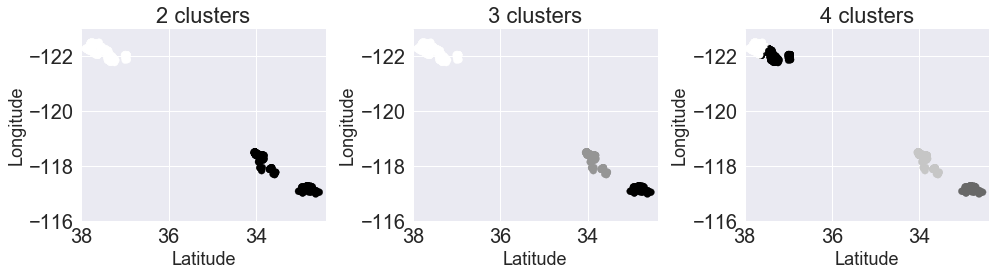

In [33]:
from sklearn.cluster import KMeans

random_state = 170
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_d)
y_pred2 = KMeans(n_clusters=2, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['latitude', 'longitude']])
y_pred3 = KMeans(n_clusters=3, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['latitude', 'longitude']])
y_pred4 = KMeans(n_clusters=4, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['latitude', 'longitude']])

plt.clf()
fig = plt.figure(figsize=(14,4))
plt.subplot(131)
plt.scatter(np.array(df_d)[:,1], np.array(df_d)[:,2], c=y_pred2)
plt.title("2 clusters", fontsize=22)
plt.xlabel('Latitude', fontsize=18); plt.ylabel('Longitude', fontsize=18); plt.ylim(-116,-123); plt.xlim(38,32.4)

plt.subplot(132)
plt.scatter(np.array(df_d)[:,1], np.array(df_d)[:,2], c=y_pred3)
plt.title("3 clusters", fontsize=22)
plt.xlabel('Latitude', fontsize=18); plt.ylabel('Longitude', fontsize=18); plt.ylim(-116,-123); plt.xlim(38,32.4)

plt.subplot(133)
plt.scatter(np.array(df_d)[:,1], np.array(df_d)[:,2], c=y_pred4)
plt.title("4 clusters", fontsize=22)
plt.xlabel('Latitude', fontsize=18); plt.ylabel('Longitude', fontsize=18); plt.ylim(-116,-123); plt.xlim(38,32.4)

plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/location_clustering.png', bbox_inches='tight')
plt.close('all')


In [34]:
random_state = 170

y_prd2 = KMeans(n_clusters=2, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['time']])
y_prd3 = KMeans(n_clusters=3, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['totalprice', 'time']])
y_prd4 = KMeans(n_clusters=4, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['totalprice', 'time']])
y_prd5 = KMeans(n_clusters=10, random_state=random_state, init='k-means++',n_init=10, verbose=0).fit_predict(df_d[['time', 'totalprice']])


plt.clf()
mpld3.enable_notebook()
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(np.array(df_d)[:,4], np.array(df_d)[:,5], c=y_prd2)
plt.title("2 clusters (just time)", fontsize=16)
plt.xlabel('Price', fontsize=18); plt.ylabel('Time', fontsize=14)

plt.subplot(132)
plt.scatter(np.array(df_d)[:,4], np.array(df_d)[:,5], c=y_prd4)
plt.title("4 clusters (time+price)", fontsize=16)
plt.xlabel('Price', fontsize=18); plt.ylabel('Time', fontsize=14)

plt.subplot(133)
plt.scatter(np.array(df_d)[:,4], np.array(df_d)[:,5], c=y_prd5)
plt.title("10 clusters (time+price)", fontsize=16)
plt.xlabel('Price', fontsize=18); plt.ylabel('Time', fontsize=14)

plt.tight_layout()
#plt.savefig('./figs/time_price_clustering.png', bbox_inches='tight')
mpld3.display()

In [35]:
mpld3.disable_notebook()

## Q5: Create any visualization of the data that you think would display meaningful insight.

In [36]:
print('There are', len(df_all.city.unique()), 'different cities. These are:')
print(df_all.city.unique())

freq_cities = df_all.groupby('city').count().reset_index()
freq_cities.sort_values(by='orderid', ascending=False, inplace=True)
print('Top 5 cities with more orders:')
freq_cities[['city', 'orderid']].head(5)

There are 59 different cities. These are:
['Daly City' 'San Francisco' 'San José' 'Alameda' 'Los Altos' 'Oakland'
 'Aptos' 'Hayward' 'Mountain View' 'South San Francisco' 'Santa Clara'
 'Santa Monica' 'San Bruno' 'Portola Valley' 'San Mateo' 'Berkeley'
 'Redwood City' 'Belmont' 'San Diego' 'Santa Cruz' 'Sunnyvale' 'Pacifica'
 'Torrance' 'Carson' 'Palo Alto' 'Emeryville' 'East Palo Alto' 'Millbrae'
 'Redondo Beach' 'Burlingame' 'Capitola' 'Cupertino' 'San Lorenzo'
 'Fullerton' 'Culver City' 'Costa Mesa' 'Woodside' 'Menlo Park'
 'Foster City' 'Stanford' 'Laguna Hills' 'Soquel' 'Marina del Rey'
 'Atherton' 'Hillsborough' 'Laguna Beach' 'Paramount' 'Hermosa Beach'
 'El Segundo' 'Chula Vista' 'LA' 'Emerald Hills' 'Downey' 'San Carlos'
 'Brisbane' 'Piedmont' 'Saratoga' 'Placentia' 'Lynwood']
Top 5 cities with more orders:


,city,orderid
45,San Francisco,994
33,Oakland,350
44,San Diego,249
41,Redwood City,128
4,Berkeley,122


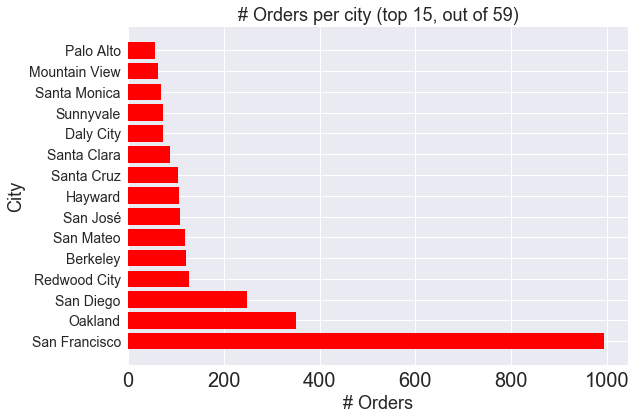

array([ 30.2771855 ,  10.66098081,   7.58452635,   3.89887298,
         3.71611331,   3.62473348,   3.28967408,   3.22875419,
         3.19829424,   2.68047518,   2.223576  ,   2.223576  ,
         2.13219616,   1.94943649,   1.70575693])

In [37]:
## Group by "city"
freq_cities = df_all.groupby('city')['orderid'].count().reset_index()
freq_cities.sort_values(by='orderid', ascending=False, inplace=True)

labels = freq_cities['city'].values
y_pos = np.arange(len(labels))
percentage_cities = freq_cities['orderid'].values/freq_cities['orderid'].sum()

plt.clf()
fig = plt.figure(figsize=(9,6))
plt.barh(y_pos[0:15], freq_cities['orderid'][0:15], align='center', color='red')
plt.title('# Orders per city (top 15, out of 59)', fontsize=18)
plt.xlabel('# Orders', fontsize=18)
plt.ylabel('City', fontsize=18)
plt.yticks(y_pos[0:15], labels[0:15], fontsize=14)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/cities_fraction.png', bbox_inches='tight')
plt.close('all')

percentage_cities[0:15]*100

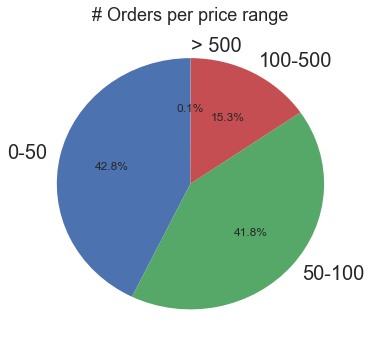

In [38]:
## Group by "price"
price_50 = df_all.totalprice[(df_all.totalprice > 0) & (df_all.totalprice < 50)]
price_100 = df_all.totalprice[(df_all.totalprice >= 50) & (df_all.totalprice < 100)]
price_500 = df_all.totalprice[(df_all.totalprice >= 100) & (df_all.totalprice < 500)]
price_1000 = df_all.totalprice[(df_all.totalprice >= 500)]

labels = ['0-50', '50-100', '100-500', '> 500']
y_pos = np.arange(len(labels))
percentage_prices = [len(price_50)/len(df_all), len(price_100)/len(df_all), 
                     len(price_500)/len(df_all), len(price_1000)/len(df_all)]

plt.clf()
fig = plt.figure(figsize=(5,5))
plt.pie(percentage_prices, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('# Orders per price range', fontsize=18)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/prices_fraction.png', bbox_inches='tight')
plt.close('all')


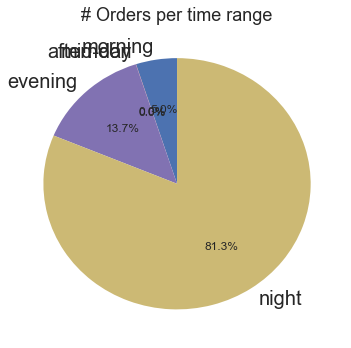

[0.049649710630520864,
 0.0,
 0.0003045994517209869,
 0.1373743527261651,
 0.812671337191593]

In [39]:
## Group by "time"
morning = df_all.totalprice[(df_all.time >= 6) & (df_all.time < 11)]
midday = df_all.totalprice[(df_all.time >= 11) & (df_all.totalprice < 14)]
afternoon = df_all.totalprice[(df_all.time >= 14) & (df_all.time < 17)]
evening = df_all.totalprice[(df_all.time >= 17) & (df_all.time < 21)]
night = df_all.totalprice[(df_all.time >= 21) | (df_all.time < 6)]

labels = ['morning', 'mid-day', 'afternoon', 'evening', 'night']
y_pos = np.arange(len(labels))
percentage_times = [len(morning)/len(df_all), len(midday)/len(df_all), len(afternoon)/len(df_all), 
                    len(evening)/len(df_all), len(night)/len(df_all)]

plt.clf()
fig = plt.figure(figsize=(5,5))
plt.pie(percentage_times, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('# Orders per time range', fontsize=18)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/times_fraction.png', bbox_inches='tight')
plt.close('all')

percentage_times

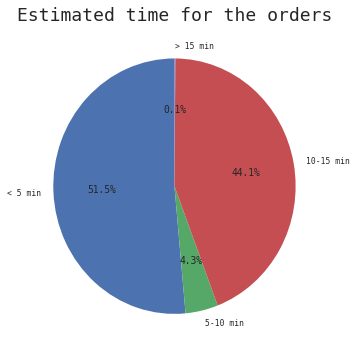

In [47]:
## Group by "estimateddeliverytime"
min5 = df_all.orderid[(df_all.estimateddeliverytime >= 0) & (df_all.estimateddeliverytime/60. < 5)]
min10 = df_all.orderid[(df_all.estimateddeliverytime/60 >= 5) & (df_all.estimateddeliverytime/60 < 10)]
min20 = df_all.orderid[(df_all.estimateddeliverytime/60 >= 1) & (df_all.estimateddeliverytime/60 < 15)]
min30 = df_all.orderid[(df_all.estimateddeliverytime/60 >= 15)]

labels = ['< 5 min', '5-10 min', '10-15 min', '> 15 min']
y_pos = np.arange(len(labels))
percentage_times = [len(min5)/len(df_all), len(min10)/len(df_all), 
                    len(min20)/len(df_all), len(min30)/len(df_all)]

plt.clf()
fig = plt.figure(figsize=(5,5))
plt.pie(percentage_times, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Estimated time for the orders', fontsize=18)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/delay_fraction.png', bbox_inches='tight')
plt.close('all')

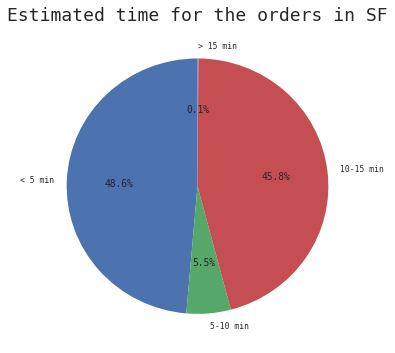

In [55]:
## Group by "estimateddeliverytime" in San Francisco
df_SF = df_all[df_all.city == 'San Francisco']
min5 = df_SF.orderid[(df_SF.estimateddeliverytime >= 0) & (df_SF.estimateddeliverytime/60. < 5)]
min10 = df_SF.orderid[(df_SF.estimateddeliverytime/60 >= 5) & (df_SF.estimateddeliverytime/60 < 10)]
min20 = df_SF.orderid[(df_SF.estimateddeliverytime/60 >= 1) & (df_SF.estimateddeliverytime/60 < 15)]
min30 = df_SF.orderid[(df_SF.estimateddeliverytime/60 >= 15)]

labels = ['< 5 min', '5-10 min', '10-15 min', '> 15 min']
y_pos = np.arange(len(labels))
percentage_times = [len(min5)/len(df_SF), len(min10)/len(df_SF), 
                    len(min20)/len(df_SF), len(min30)/len(df_SF)]

plt.clf()
fig = plt.figure(figsize=(5.7,5))
plt.pie(percentage_times, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Estimated time for the orders in SF', fontsize=18)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/delay_fraction_SF.png', bbox_inches='tight')
plt.close('all')


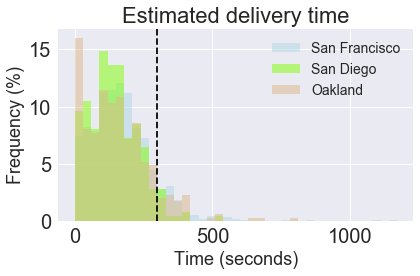

In [42]:
df_SF = df_all[df_all.city == 'San Francisco']
df_PA = df_all[df_all.city == 'Palo Alto']
df_LA = df_all[df_all.city == 'LA']
df_SD = df_all[df_all.city == 'San Diego']
df_Oak = df_all[df_all.city == 'Oakland']
binwidth = 30
weight_SF = 100 * np.ones_like(df_SF.estimateddeliverytime) / df_SF.estimateddeliverytime.size
weight_PA = 100 * np.ones_like(df_PA.estimateddeliverytime) / df_PA.estimateddeliverytime.size
weight_LA = 100 * np.ones_like(df_LA.estimateddeliverytime) / df_LA.estimateddeliverytime.size
weight_SD = 100 * np.ones_like(df_SD.estimateddeliverytime) / df_SD.estimateddeliverytime.size
weight_Oak = 100 * np.ones_like(df_Oak.estimateddeliverytime) / df_Oak.estimateddeliverytime.size

plt.clf()
fig, plt.figure(figsize=(6,4))
plt.hist(np.array(df_SF.estimateddeliverytime), color='lightblue', alpha=0.5, label='San Francisco', 
         weights=weight_SF, bins=np.arange(min(df_SF.estimateddeliverytime), 
                        max(df_SF.estimateddeliverytime) + binwidth, binwidth))
#plt.hist(np.array(df_PA.estimateddeliverytime), color='salmon', alpha=0.5, label='Palo Alto',
#         weights=weight_PA, bins=np.arange(min(df_PA.estimateddeliverytime), 
#                        max(df_PL.estimateddeliverytime) + binwidth, binwidth))
#plt.hist(np.array(df_LA.estimateddeliverytime), color='chartreuse', alpha=0.5, label='Los Angeles',
#         weights=weight_LA, bins=np.arange(min(df_LA.estimateddeliverytime), 
#                        max(df_LA.estimateddeliverytime) + binwidth, binwidth))
plt.hist(np.array(df_SD.estimateddeliverytime), color='chartreuse', alpha=0.5, label='San Diego',
         weights=weight_SD, bins=np.arange(min(df_SD.estimateddeliverytime), 
                        max(df_SD.estimateddeliverytime) + binwidth, binwidth))
plt.hist(np.array(df_Oak.estimateddeliverytime), color='burlywood', alpha=0.5, label='Oakland',
         weights=weight_Oak, bins=np.arange(min(df_Oak.estimateddeliverytime), 
                        max(df_Oak.estimateddeliverytime) + binwidth, binwidth))
plt.axvline(60*5., color='black', linestyle='--')
plt.title("Estimated delivery time", fontsize=22)
plt.xlabel('Time (seconds)', fontsize=18); plt.ylabel('Frequency (%)', fontsize=18)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/hist_timedelay_cities.png', bbox_inches='tight')
plt.close('all')


How many orders have a delivery estimate above 5 minutes (assuming that the estimated delivery time is given in seconds)?

In [43]:
print('Across the whole CA,', len(df_all[df_all.estimateddeliverytime < 5*60]) / len(df_all)*100, 
      '% of the orders are delivered within 5 minutes')

print('In SF,', len(df_SF[df_SF.estimateddeliverytime < 5*60]) / len(df_SF)*100, 
      '% of the orders are delivered within 5 minutes')

print('In Oakland,', len(df_Oak[df_Oak.estimateddeliverytime < 5*60]) / len(df_Oak)*100, 
      '% of the orders are delivered within 5 minutes')

print('In San Diego,', len(df_SD[df_SD.estimateddeliverytime < 5*60]) / len(df_SD)*100, 
      '% of the orders are delivered within 5 minutes')

print('In LA,', len(df_LA[df_LA.estimateddeliverytime < 5*60]) / len(df_LA)*100, 
      '% of the orders are delivered within 5 minutes')

print('In Palo Alto,', len(df_PA[df_PA.estimateddeliverytime < 5*60]) / len(df_PA)*100, 
      '% of the orders are delivered within 5 minutes')

Across the whole CA, 91.68443496801706 % of the orders are delivered within 5 minutes
In SF, 89.33601609657947 % of the orders are delivered within 5 minutes
In Oakland, 90.0 % of the orders are delivered within 5 minutes
In San Diego, 95.18072289156626 % of the orders are delivered within 5 minutes
In LA, 75.0 % of the orders are delivered within 5 minutes
In Palo Alto, 83.92857142857143 % of the orders are delivered within 5 minutes


Across the whole CA, 91.7% of the orders are delivered within 5 minutes. <br>
In SF, 89.3% of the orders are delivered within 5 minutes. <br>
In Oakland, 90.0% of the orders are delivered within 5 minutes. <br>
In San Diego, 95.2% of the orders are delivered within 5 minutes. <br>
In LA, 75.0% of the orders are delivered within 5 minutes. <br>
In Palo Alto, 83.9% of the orders are delivered within 5 minutes. <br>

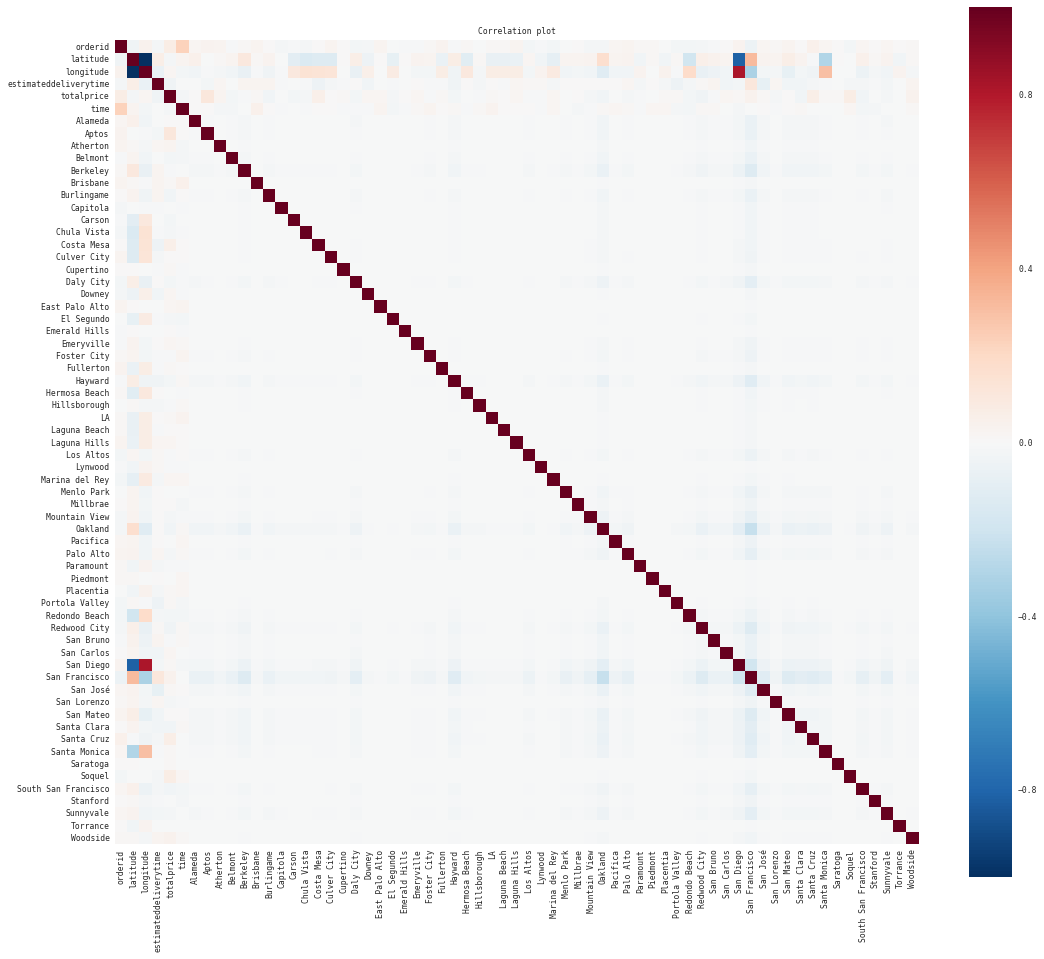

Pearson correlation between "totalprice" and "time": -0.02


In [44]:
## Correlation matrix:

sns.set(context="paper", font="monospace")
corrmat = df_d.corr()

plt.clf()
f, ax = plt.subplots(figsize=(18,16))
sns.heatmap(corrmat, vmax=1.0, square=True) #Draw the heatmap using seaborn
ax.set_title('Correlation plot', size=16)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(8)

plt.show()

print('Pearson correlation between "totalprice" and "time":', "%2.2f" % (corrmat['totalprice']['time']))

## Q6: Explain (at a high level) how you could use any insights derived above to advance the company financially

In order to help the company to advance financially, I would check which users are worth targeting:
-	I would check where most of the orders are placed, and focus on these areas.
-	Are there regions where the estimated delivery time exceeds 5 minutes more often? If so, I would in depth these areas to find out reasons and improve it (i.e. more couriers?).
-	I would pay special attention to users who spend more money than on average, since these users are valuable as well. What can we learn from them? Where are these users located? Are they single time users or do they make several purchases over time?
-	If we do not have information about the user, we can get it indirectly from other sources: We can get information about the IP address used to make the purchase and link it to a particular user; or even link it to a fixed location and device of a user. Once we have more information about our customers; can we find patterns in their purchases (order preferences, periodic orders, …)?
-	We can also try to find out how the user learned about Eaze at first, and improve the marketing strategy of the company, i.e. focusing on the sources which are used most (e.g. social media vs the radio).

-	It is worth to check if there is any correlation between the number of orders, or order value, with the wealth index of the neighborhood. I am expecting the wealth of different areas to be a parameter that can provide further insights; augmenting this information would be interesting. 
-	Obtaining the location [latitude, longitude] of all dispensaries in CA (or at least in big cities that are important markets for Eaze, such as San Francisco, Oakland, or San Diego) can also be interesting. We already know that the orders are done out of business hours; are users also placing an order because they do not have a dispensary nearby?
-	It could be interesting to “normalize” the results by the population density (based on data from the U.S. census bureau) to find high demand areas, as the number of orders is likely biased towards population density. 